In [468]:
import numpy as np
from matplotlib import pyplot as plt
import csv
from datetime import datetime

Modifiable Parmas
==================

Change the parameters in the following cell to change properties of the plot at the bottom

In [494]:
field = ['cases', 'deaths'][0] # switch index to do cases vs deaths
state = 'Georgia' # switch to, e.g., 'New York'
smoothing_window = 10 # use any positive integer, but values above 5 work best

Read the data
=============

Code and helper utils for actually ingesting the data

In [495]:
fname = "covid-19-data/us-counties.csv"

In [496]:
csv_reader = csv.DictReader(open(fname))
data = [d for d in csv_reader if d['state'] == state]

In [497]:
def entry_to_days(entry):
    """Converts a YYYY-mm-dd date into an integer with 0 being 2020-01-01"""
    d1 = datetime.strptime(entry['date'], "%Y-%m-%d")
    d0 = datetime.strptime("2020-01-01", "%Y-%m-%d")
    return(d1 - d0).days

In [498]:
# Here we just peek at a cell in the data
data[0]

OrderedDict([('date', '2020-03-02'),
             ('county', 'Fulton'),
             ('state', 'Georgia'),
             ('fips', '13121'),
             ('cases', '2'),
             ('deaths', '0')])

In [499]:
# Now we extract data for all counties in this state
counties = {}
for d in data:
    l = counties.get(d['county'], [])
    l.append([entry_to_days(d), d[field]])
    counties[d['county']] = l

In [500]:
len(counties)

158

Code to extract a trajectory for an individual county and plot it
========================

TODO: write up the whole log-log phase plot thing.

In [501]:
def trajectory(county, window=5):
    raw = sorted(counties[county], key = lambda e: e[0])
    rates = [(float(raw[i][1]) - float(raw[i-window][1])) / (raw[i][0] - raw[i-window][0])
             for i in range(window, len(raw))]
    cums = [float(r[1]) for r in raw[window:]]
    indices = [i for i in range(len(cums)) if cums[i] > 1 and rates[i] > 1]
    return [[cums[i] for i in indices], [rates[i] for i in indices]]

In [502]:
def plot_traj(county, color, window=5):
    data = trajectory(county, window=window)
    plt.yscale('log')
    plt.xscale('log')
    plt.ylabel('average new ' + field +' per day')
    plt.xlabel('cumulative ' + field)
    plt.plot(data[0], data[1], color, label=county)

Helper class for grabbing different colors and line styles for plotting

In [503]:
class ColorPicker:
    def __init__(self):
        self.colors = [c + "-" for c in "kbrgcm"] + [c + "--" for c in "kbrgcm"]
        self.i = 0
    def get(self):
        c = self.colors[self.i]
        self.i += 1
        self.i = self.i % len(self.colors)
        return c




THE ACTUAL PLOTS
================

The part you've been waiting for, amirite?

Fulton cumulative cases : 2785.0
DeKalb cumulative cases : 1980.0
Gwinnett cumulative cases : 1744.0
Cobb cumulative cases : 1581.0
Dougherty cumulative cases : 1500.0
Hall cumulative cases : 1261.0
Clayton cumulative cases : 693.0
Henry cumulative cases : 495.0
Cherokee cumulative cases : 457.0
Richmond cumulative cases : 390.0
Sumter cumulative cases : 378.0
Carroll cumulative cases : 348.0


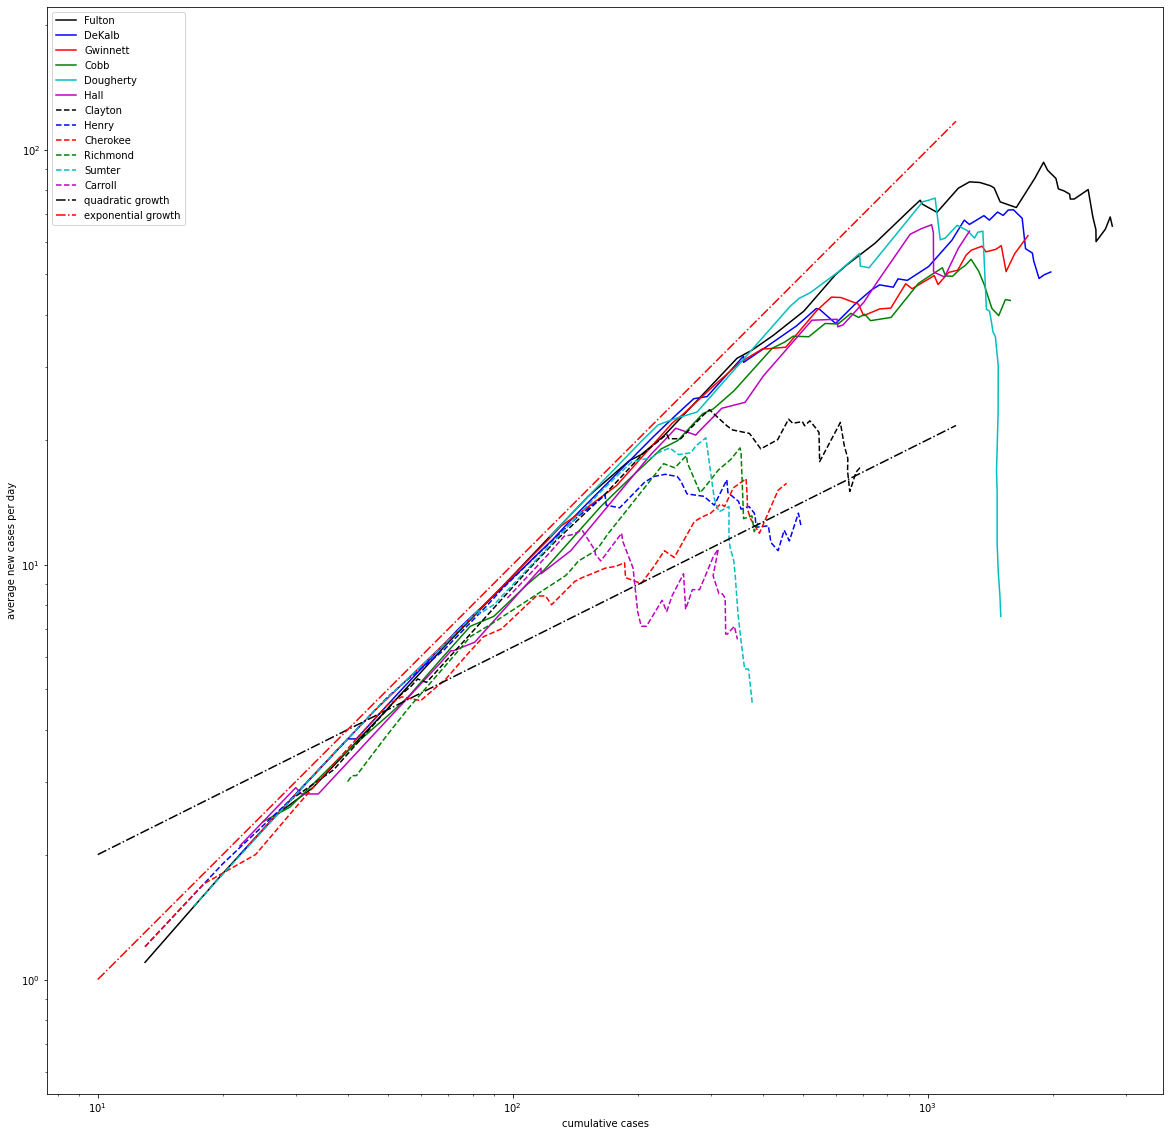

In [504]:
col_pick = ColorPicker()
plt.rcParams['figure.figsize'] = [20,20]
plt.axes().set_aspect('equal', 'datalim')
maxpt = 0.0
valid_counties = [c for c in counties.keys() if len(trajectory(c)[0]) > smoothing_window and c != 'Unknown']
valid_counties = sorted(valid_counties, key=lambda c: -1.0 * trajectory(c)[0][-1])
for county in valid_counties[:12]:
    plot_traj(county, col_pick.get(), window=smoothing_window)
    print(county + " cumulative " + field + " : "+ str(trajectory(county)[0][-1]))
    maxpt = max(maxpt, t[0][-1])
plt.plot([10.0, maxpt], [2.0, 2.0 * np.sqrt(0.1 * maxpt)], 'k-.', label="quadratic growth")
plt.plot([10.0, maxpt], [1.0, 0.1 * maxpt], 'r-.', label="exponential growth")
plt.legend()